In [76]:
from configparser import ConfigParser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
config = ConfigParser()
config.read("config.ini", 'UTF-8')
BTC_PATH = config.get("default", "PATH")

In [112]:
def data_prep():
    df = pd.read_pickle(BTC_PATH)

    # 対数収益率に変換
    df['return'] = df['cl']/df['cl'].shift(1)-1

    # 欠損値処理
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    return df

In [129]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

def walk_forward_backtest(df, window_size, forecast_horizon, upper_threshold, lower_threshold):
    """
    ウォークフォワード法によるバックテスト

    Args:
        df: データフレーム
        window_size: 学習データのウィンドウサイズ
        forecast_horizon: 予測期間
        upper_threshold: ショートのトリガーとなる上位パーセンタイル
        lower_threshold: ロングのトリガーとなる上位パーセンタイル
    """

    positions = []
    # portfolio = []
    # initial_capital = 1000

    for start in range(window_size, len(df) - forecast_horizon, forecast_horizon):
        # 学習データとテストデータの分割
        train_data = df.iloc[start-window_size:start]
        # test_data = df.iloc[start:start+forecast_horizon]

        # カルマンフィルタの学習
        kf = KalmanFilter(
            transition_matrices=[[1]],
            observation_matrices=[[1]],
            initial_state_mean=0,
            initial_state_covariance=1.0,
            observation_covariance=1.0,
            transition_covariance=.01
        )
        state_means, state_covariances = kf.filter(train_data['return'].values)

        # Nステップ先予測
        n_steps = forecast_horizon
        predicted_state_means, predicted_state_covariances = predict_n_steps(kf, state_means[-1], state_covariances[-1], n_steps)


        # 90%信頼区間を計算
        lower_bounds = predicted_state_means.flatten() - 3 * np.sqrt(predicted_state_covariances.flatten())
        upper_bounds = predicted_state_means.flatten() + 3 * np.sqrt(predicted_state_covariances.flatten())

        lower_bounds2 = predicted_state_means.flatten() - 1 * np.sqrt(predicted_state_covariances.flatten())
        upper_bounds2 = predicted_state_means.flatten() + 1 * np.sqrt(predicted_state_covariances.flatten())


        # 予測値から実際の価格に戻す
        predicted_price = np.cumprod(predicted_state_means+1) * df['cl'].iloc[start-1]

        # ポジション決定
        i=forecast_horizon-1
        upper_bound = upper_bounds[-1] if len(positions)==0 or positions[-1]==0 else upper_bounds2[-1]
        lower_bound = lower_bounds[-1] if len(positions)==0 or positions[-1]==0 else lower_bounds2[-1]
        if predicted_price[i] > upper_bound:
            positions.append(-1)  # ショート
        elif predicted_price[i] < lower_bound:
            positions.append(1)  # ロング            
        else:
            positions.append(0)  # 中立

        # 資産の推移計算
        # portfolio.append(initial_capital * np.prod(1 + np.array(positions) * test_data['return'].values))

    return positions

def predict_n_steps(kf, initial_state_mean, initial_state_covariance, n_steps):
    """
    Nステップ先の予測を行う関数

    Args:
        kf: カルマンフィルタのインスタンス
        initial_state_mean: 初期状態の平均
        initial_state_covariance: 初期状態の共分散
        n_steps: 予測ステップ数

    Returns:
        predicted_state_means: Nステップ先の予測値の平均
        predicted_state_covariances: Nステップ先の予測値の共分散
    """

    state_means = [initial_state_mean]
    state_covariances = [initial_state_covariance]
    transition_matrix = np.array(kf.transition_matrices)  # 状態遷移行列
    process_noise_cov = kf.transition_covariance  # プロセスノイズの共分散

    for _ in range(n_steps):
        # 1ステップ先の予測
        predicted_state_mean, predicted_state_covariance = kf.filter_update(
            filtered_state_mean=state_means[-1],
            filtered_state_covariance=state_covariances[-1]
        )
        state_means.append(predicted_state_mean)
        state_covariances.append(predicted_state_covariance)

        # Nステップ先の予測誤差共分散の更新
        state_covariances[-1] = transition_matrix @ state_covariances[-2] @ transition_matrix.T + process_noise_cov

    return np.array(state_means), np.array(state_covariances)

# データの準備 (例)
df = data_prep()

# パラメータ設定
window_size = 100
forecast_horizon = 90
upper_threshold = 5
lower_threshold = 95

# バックテスト実行
positions = walk_forward_backtest(df, window_size, forecast_horizon, upper_threshold, lower_threshold)

In [130]:
cum_posisions = np.array(positions).cumsum()

In [131]:
returns = df["return"].iloc[-len(cum_posisions):]
cum_returns = (1+returns*cum_posisions/100).cumprod()

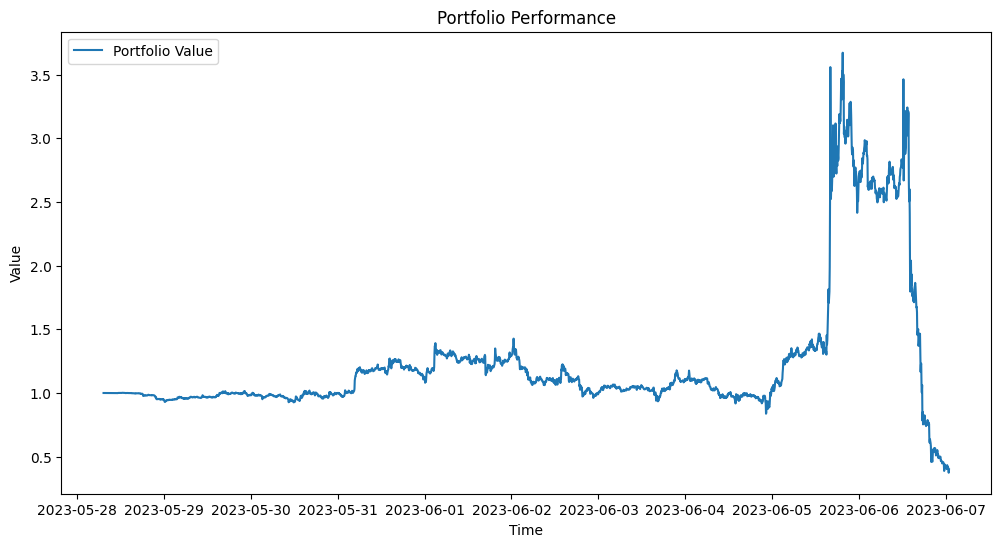

In [132]:
# 結果の可視化
plt.figure(figsize=(12, 6))
plt.plot(cum_returns, label='Portfolio Value')
plt.legend()
plt.title('Portfolio Performance')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()